# EDA with the different graph structures

In [1]:
import os
# set the directory to the root
os.chdir("/Users/jeandurand/Documents/Masters Thesis/causal_bayes_opt")
from utils.graph_utils.graph_6_nodes import Graph6Nodes
from utils.sem_sampling import sample_model
from algorithms.CBO_algorithm import CBO
from algorithms.BO_algorithm import BO

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


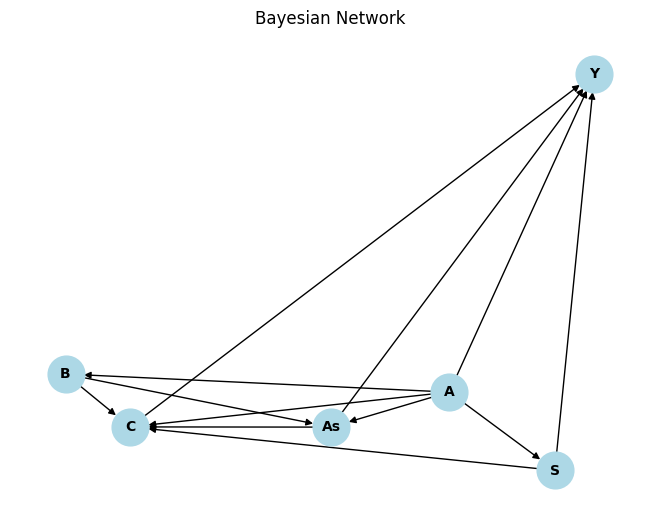

In [2]:
graph = Graph6Nodes()
graph.show_graphical_model()

In [3]:
algo = CBO("Graph6")
algo.run_algorithm()

INFO:root:Setting up the 6 nodes graph
INFO:root:Fitting each sample to the graph based on the parents
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:root:Using the fixed equal cost structure
INFO:root:------ Iteration 0: Observed 1, where epsilon = 0.2915172617885139 ------
INFO:root:------ Iteration 1: Intervened 1 where epsilon = 0.3300457172418056  ------
INFO:root:Using the Causal Gaussian Prior
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding ke

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 1